In [38]:
# -*- coding:utf-8 -*-
# bert文本分类baseline模型
# model: bert
# date: 2021.10.10 10:01

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [39]:
train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
batch_size = 2
epoches = 100
model = "bert-base-chinese"
hidden_size = 768
n_class = 2
maxlen = 8

In [41]:
# data
sentences = ["我喜欢打篮球", "这个相机很好看", "今天玩的特别开心", "我不喜欢你", "太糟糕了", "真是件令人伤心的事情"]
labels = [1, 1, 1, 0, 0, 0]  # 1积极, 0消极.

# word_list = ' '.join(sentences).split()
# word_list = list(set(word_list))
# word_dict = {w: i for i, w in enumerate(word_list)}
# num_dict = {i: w for w, i in word_dict.items()}
# vocab_size = len(word_list)

In [42]:
class MyDataset(Data.Dataset):
  def __init__(self, sentences, labels=None, with_labels=True,):
    self.tokenizer = AutoTokenizer.from_pretrained(model)
    self.with_labels = with_labels
    self.sentences = sentences
    self.labels = labels
  def __len__(self):
    return len(sentences)

  def __getitem__(self, index):
    # Selecting sentence1 and sentence2 at the specified index in the data frame
    sent = self.sentences[index]

    # Tokenize the pair of sentences to get token ids, attention masks and token type ids
    encoded_pair = self.tokenizer(sent,
                    padding='max_length',  # Pad to max_length
                    truncation=True,       # Truncate to max_length
                    max_length=maxlen,  
                    return_tensors='pt')  # Return torch.Tensor objects

    token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
    attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
    token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

    if self.with_labels:  # True if the dataset has labels
      label = self.labels[index]
      return token_ids, attn_masks, token_type_ids, label
    else:
      return token_ids, attn_masks, token_type_ids

In [43]:
train = Data.DataLoader(dataset=MyDataset(sentences, labels), batch_size=batch_size, shuffle=True, num_workers=1)

In [44]:
# model
class BertClassify(nn.Module):
  def __init__(self):
    super(BertClassify, self).__init__()
    self.bert = AutoModel.from_pretrained(model, output_hidden_states=True, return_dict=True)
    self.linear = nn.Linear(hidden_size, n_class)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, X):
    input_ids, attention_mask, token_type_ids = X[0], X[1], X[2]
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) # 返回一个output字典
    # 用最后一层cls向量做分类
    # outputs.pooler_output: [bs, hidden_size]
    logits = self.linear(self.dropout(outputs.pooler_output))
    
    return logits

In [45]:
bc = BertClassify().to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
optimizer = optim.Adam(bc.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [47]:
# train
sum_loss = 0
total_step = len(train)
for epoch in range(epoches):
  for i, batch in enumerate(train):
    optimizer.zero_grad()
    batch = tuple(p.to(device) for p in batch)
    pred = bc([batch[0], batch[1], batch[2]])
    loss = loss_fn(pred, batch[3])
    sum_loss += loss.item()

    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
      print('[{}|{}] step:{}/{} loss:{:.4f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
  train_curve.append(sum_loss)
  sum_loss = 0

[1|100] step:1/3 loss:1.1500
[1|100] step:2/3 loss:1.2046
[1|100] step:3/3 loss:2.5194
[11|100] step:1/3 loss:1.1471
[11|100] step:2/3 loss:0.7017
[11|100] step:3/3 loss:0.8367
[21|100] step:1/3 loss:1.0529
[21|100] step:2/3 loss:1.4519
[21|100] step:3/3 loss:1.4188
[31|100] step:1/3 loss:1.2525
[31|100] step:2/3 loss:1.2894
[31|100] step:3/3 loss:0.6796
[41|100] step:1/3 loss:1.2206
[41|100] step:2/3 loss:0.7903
[41|100] step:3/3 loss:0.9456
[51|100] step:1/3 loss:0.4095
[51|100] step:2/3 loss:0.4227
[51|100] step:3/3 loss:1.7919
[61|100] step:1/3 loss:2.2079
[61|100] step:2/3 loss:1.0230
[61|100] step:3/3 loss:1.0512
[71|100] step:1/3 loss:0.5453
[71|100] step:2/3 loss:0.2571
[71|100] step:3/3 loss:1.0071
[81|100] step:1/3 loss:1.1741
[81|100] step:2/3 loss:0.6857
[81|100] step:3/3 loss:0.2532
[91|100] step:1/3 loss:0.5687
[91|100] step:2/3 loss:0.4335
[91|100] step:3/3 loss:0.8573


In [52]:
# test
bc.eval()
with torch.no_grad():
  test_text = ['我不喜欢打篮球']
  test = MyDataset(test_text, labels=None, with_labels=False)
  x = test.__getitem__(0)
  x = tuple(p.unsqueeze(0).to(device) for p in x)
  pred = bc([x[0], x[1], x[2]])
  pred = pred.data.max(dim=1, keepdim=True)[1]
  if pred[0][0] == 0:
    print('消极')
  else:
    print('积极')

消极


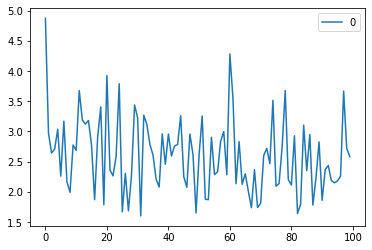

In [51]:
pd.DataFrame(train_curve).plot() # loss曲线